# Classification using a Neural Network - Handle Class Imbalance (Pytorch)
The dataset is from https://www.kaggle.com/c/GiveMeSomeCredit <br>
"Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted."  <br>
We will build an MLP classifier to predict if someone will experience financial distress and therefore cannot pay off credit card (i.e. default). It is a binary classificaiton problem: default (class-1) or not default  (class-0) <br>
Real dataset is often imbalanced: class-i may have much more data samples than class-j.

In [90]:
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset as torch_dataset
from torch.utils.data import DataLoader as torch_dataloader

### Load the data

In [91]:
#every row of the table is a data sample (feature vector) from a person
df = pd.read_csv('cs_data.csv')
df.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


#### handle nan (null) in data (i.e. missing values)
Some fields in the table are nan, which are missing values. <br>
For example, someone may not want to reveal monthly income to whoever made the table/survey, then the table got nan.

In [92]:
df.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [93]:
#here, we use a simple method:
#replace nan in each column with median value of that column
#there are other methods in pandas and sklearn: interpolation in pandas and KNNImputer in sklearn
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(df.values)
df=pd.DataFrame(data=dfv, columns=df.columns)
df.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### We have a highly imbalanced dataset
139974 data samples in class-0 (normal) <br>
10026 data samples in class-1 (financial distress)

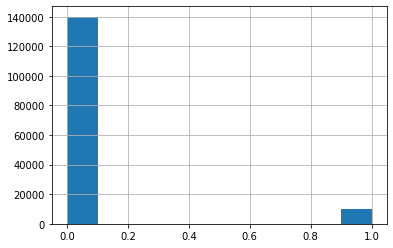

In [94]:
df['SeriousDlqin2yrs'].hist()

#### Classification Goal: predict 'SeriousDlqin2yrs' (Y) using the other features (X)

In [95]:
#'SeriousDlqin2yrs' is the target/class label, so it should not be in the input feature vector X
#'id' of a person is useless for the classification task
#so, we remove them from the table and get the input X
X=df.drop(['SeriousDlqin2yrs', 'id'], axis=1)
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45.0,2.0,0.802982,9120.0,13.0,0.0,6.0,0.0,2.0
1,0.957151,40.0,0.0,0.121876,2600.0,4.0,0.0,0.0,0.0,1.0
2,0.658180,38.0,1.0,0.085113,3042.0,2.0,1.0,0.0,0.0,0.0
3,0.233810,30.0,0.0,0.036050,3300.0,5.0,0.0,0.0,0.0,0.0
4,0.907239,49.0,1.0,0.024926,63588.0,7.0,0.0,1.0,0.0,0.0


In [96]:
#Y is the target/class label
Y=df['SeriousDlqin2yrs']
Y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: SeriousDlqin2yrs, dtype: float64

In [97]:
# convert pandas dataframe/series to numpy array
# sklearn functions may not work well with pandas data types
X=X.values
Y=Y.values

### create training, validation and test sets

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
#split X_train and Y_train into a 'pure' training set and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)
print('train:', X_train.shape, Y_train.shape)
print('validation:', X_val.shape, Y_val.shape)
print('test:', X_test.shape, Y_test.shape)

train: (108000, 10) (108000,)
validation: (12000, 10) (12000,)
test: (30000, 10) (30000,)


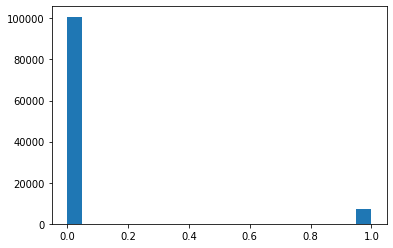

In [99]:
plt.hist(Y_train, bins=20);

Let's do upsampling for class-1

In [100]:
from sklearn.utils import resample
X_train_c1  = resample(X_train[Y_train==1], n_samples=100824)
Y_train_c1 = np.ones(X_train_c1.shape[0])
print('X_train_c1', X_train_c1.shape, Y_train_c1.shape)
X_train=np.concatenate([X_train[Y_train==0], X_train_c1], axis=0)
Y_train=np.concatenate([Y_train[Y_train==0], Y_train_c1], axis=0)
print('X_train.shape after upsampling', X_train.shape)
print('Y_train.shape after upsampling', Y_train.shape)

X_train_c1 (100824, 10) (100824,)
X_train.shape after upsampling (201648, 10)
Y_train.shape after upsampling (201648,)


In [101]:
#apply feature normalization to training, validation and test sets
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(X_train) # think about why fit to X_train, not X ?
X_train=scaler.transform(X_train)
X_val=scaler.transform(X_val)
X_test=scaler.transform(X_test)

### we need to use weighted classification accuracy

In [102]:
# we need to use weighted classification accuracy
# try to understand it
def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

## Your task begins here <br>
see NN_binary_classification_Pytorch.ipynb in Lecture 16 <br>
try Adma with lr=0.001 <br>
Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
If you have plenty of time and enough computing power, try to find better hyperparameters <br>
read papers about "Neural Architecture Search" https://arxiv.org/abs/1808.05377 <br>

You need to modify the function `test` in order to use weighted_accuracy, see `test_acc` in H3P2T1_Keras.ipynb

### define a dataset to hold/represent the data 

In [171]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        # self.X[idx] is numpy array, we need to convert it to torch tensor
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32) #it needs to be float, not int
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [172]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [173]:
# get the first data point in the training set
# dataset_train[0][0] is x0
# dataset_train[0][1] is y0
dataset_train[0][0].shape

torch.Size([10])

In [174]:
# the class label of the first training sample x0
dataset_train[0][1]

tensor(0.)

In [175]:
len(dataset_train) # get the number of data points in the training set

201648

### Create dataloaders which will be used to generate minibatches
batch_size=N means each minibatch contains N data points  <br>
note: the last minibatch may contain less than N data points

In [176]:
#we must shuffle data points in the training set, set shuffle=True
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [177]:
len(dataloader_train) # get the number of minibatches

3151

In [178]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        # X contain the data samples in a mini-batch
        # Y contain the class lables of these samples
        print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 10]) torch.Size([64])
1 torch.Size([64, 10]) torch.Size([64])
2 torch.Size([64, 10]) torch.Size([64])
3 torch.Size([64, 10]) torch.Size([64])
4 torch.Size([64, 10]) torch.Size([64])
5 torch.Size([64, 10]) torch.Size([64])
6 torch.Size([64, 10]) torch.Size([64])
7 torch.Size([64, 10]) torch.Size([64])
8 torch.Size([64, 10]) torch.Size([64])
9 torch.Size([64, 10]) torch.Size([64])
10 torch.Size([64, 10]) torch.Size([64])
11 torch.Size([64, 10]) torch.Size([64])
12 torch.Size([64, 10]) torch.Size([64])
13 torch.Size([64, 10]) torch.Size([64])
14 torch.Size([64, 10]) torch.Size([64])
15 torch.Size([64, 10]) torch.Size([64])
16 torch.Size([64, 10]) torch.Size([64])
17 torch.Size([64, 10]) torch.Size([64])
18 torch.Size([64, 10]) torch.Size([64])
19 torch.Size([64, 10]) torch.Size([64])
20 torch.Size([64, 10]) torch.Size([64])
21 torch.Size([64, 10]) torch.Size([64])
22 torch.Size([64, 10]) torch.Size([64])
23 torch.Size([64, 10]) torch.Size([64])
24 torch.Size([64, 10]) to

197 torch.Size([64, 10]) torch.Size([64])
198 torch.Size([64, 10]) torch.Size([64])
199 torch.Size([64, 10]) torch.Size([64])
200 torch.Size([64, 10]) torch.Size([64])
201 torch.Size([64, 10]) torch.Size([64])
202 torch.Size([64, 10]) torch.Size([64])
203 torch.Size([64, 10]) torch.Size([64])
204 torch.Size([64, 10]) torch.Size([64])
205 torch.Size([64, 10]) torch.Size([64])
206 torch.Size([64, 10]) torch.Size([64])
207 torch.Size([64, 10]) torch.Size([64])
208 torch.Size([64, 10]) torch.Size([64])
209 torch.Size([64, 10]) torch.Size([64])
210 torch.Size([64, 10]) torch.Size([64])
211 torch.Size([64, 10]) torch.Size([64])
212 torch.Size([64, 10]) torch.Size([64])
213 torch.Size([64, 10]) torch.Size([64])
214 torch.Size([64, 10]) torch.Size([64])
215 torch.Size([64, 10]) torch.Size([64])
216 torch.Size([64, 10]) torch.Size([64])
217 torch.Size([64, 10]) torch.Size([64])
218 torch.Size([64, 10]) torch.Size([64])
219 torch.Size([64, 10]) torch.Size([64])
220 torch.Size([64, 10]) torch.Siz

392 torch.Size([64, 10]) torch.Size([64])
393 torch.Size([64, 10]) torch.Size([64])
394 torch.Size([64, 10]) torch.Size([64])
395 torch.Size([64, 10]) torch.Size([64])
396 torch.Size([64, 10]) torch.Size([64])
397 torch.Size([64, 10]) torch.Size([64])
398 torch.Size([64, 10]) torch.Size([64])
399 torch.Size([64, 10]) torch.Size([64])
400 torch.Size([64, 10]) torch.Size([64])
401 torch.Size([64, 10]) torch.Size([64])
402 torch.Size([64, 10]) torch.Size([64])
403 torch.Size([64, 10]) torch.Size([64])
404 torch.Size([64, 10]) torch.Size([64])
405 torch.Size([64, 10]) torch.Size([64])
406 torch.Size([64, 10]) torch.Size([64])
407 torch.Size([64, 10]) torch.Size([64])
408 torch.Size([64, 10]) torch.Size([64])
409 torch.Size([64, 10]) torch.Size([64])
410 torch.Size([64, 10]) torch.Size([64])
411 torch.Size([64, 10]) torch.Size([64])
412 torch.Size([64, 10]) torch.Size([64])
413 torch.Size([64, 10]) torch.Size([64])
414 torch.Size([64, 10]) torch.Size([64])
415 torch.Size([64, 10]) torch.Siz

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([64])
679 torch.Size([64, 10]) torch.Size([64])
680 torch.Size([64, 10]) torch.Size([64])
681 torch.Size([64, 10]) torch.Size([64])
682 torch.Size([64, 10]) torch.Size([64])
683 torch.Size([64, 10]) torch.Size([64])
684 torch.Size([64, 10]) torch.Size([64])
685 torch.Size([64, 10]) torch.Size([64])
686 torch.Size([64, 10]) torch.Size([64])
687 torch.Size([64, 10]) torch.Size([64])
688 torch.Size([64, 10]) torch.Size([64])
689 torch.Size([64, 10]) torch.Size([64])
690 torch.Size([64, 10]) torch.Size([64])
691 torch.Size([64, 10]) torch.Size([64])
692 torch.Size([64, 10]) torch.Size([64])
693 torch.Size([64, 10]) torch.Size([64])
694 torch.Size([64, 10]) torch.Size([64])
695 torch.Size([64, 10]) torch.Size([64])
696 torch.Size([64, 10]) torch.Size([64])
697 torch.Size([64, 10]) torch.Size([64])
698 torch.Size([64, 10]) torch.Size([64])
699 torch.Size([64, 10]) torch.Size([64])
700 torch.Size([64, 10]) torch.Size([64])
701 torch.Size([64, 10]) torch.Size([64])
702 torch.Size([

873 torch.Size([64, 10]) torch.Size([64])
874 torch.Size([64, 10]) torch.Size([64])
875 torch.Size([64, 10]) torch.Size([64])
876 torch.Size([64, 10]) torch.Size([64])
877 torch.Size([64, 10]) torch.Size([64])
878 torch.Size([64, 10]) torch.Size([64])
879 torch.Size([64, 10]) torch.Size([64])
880 torch.Size([64, 10]) torch.Size([64])
881 torch.Size([64, 10]) torch.Size([64])
882 torch.Size([64, 10]) torch.Size([64])
883 torch.Size([64, 10]) torch.Size([64])
884 torch.Size([64, 10]) torch.Size([64])
885 torch.Size([64, 10]) torch.Size([64])
886 torch.Size([64, 10]) torch.Size([64])
887 torch.Size([64, 10]) torch.Size([64])
888 torch.Size([64, 10]) torch.Size([64])
889 torch.Size([64, 10]) torch.Size([64])
890 torch.Size([64, 10]) torch.Size([64])
891 torch.Size([64, 10]) torch.Size([64])
892 torch.Size([64, 10]) torch.Size([64])
893 torch.Size([64, 10]) torch.Size([64])
894 torch.Size([64, 10]) torch.Size([64])
895 torch.Size([64, 10]) torch.Size([64])
896 torch.Size([64, 10]) torch.Siz

1066 torch.Size([64, 10]) torch.Size([64])
1067 torch.Size([64, 10]) torch.Size([64])
1068 torch.Size([64, 10]) torch.Size([64])
1069 torch.Size([64, 10]) torch.Size([64])
1070 torch.Size([64, 10]) torch.Size([64])
1071 torch.Size([64, 10]) torch.Size([64])
1072 torch.Size([64, 10]) torch.Size([64])
1073 torch.Size([64, 10]) torch.Size([64])
1074 torch.Size([64, 10]) torch.Size([64])
1075 torch.Size([64, 10]) torch.Size([64])
1076 torch.Size([64, 10]) torch.Size([64])
1077 torch.Size([64, 10]) torch.Size([64])
1078 torch.Size([64, 10]) torch.Size([64])
1079 torch.Size([64, 10]) torch.Size([64])
1080 torch.Size([64, 10]) torch.Size([64])
1081 torch.Size([64, 10]) torch.Size([64])
1082 torch.Size([64, 10]) torch.Size([64])
1083 torch.Size([64, 10]) torch.Size([64])
1084 torch.Size([64, 10]) torch.Size([64])
1085 torch.Size([64, 10]) torch.Size([64])
1086 torch.Size([64, 10]) torch.Size([64])
1087 torch.Size([64, 10]) torch.Size([64])
1088 torch.Size([64, 10]) torch.Size([64])
1089 torch.

1256 torch.Size([64, 10]) torch.Size([64])
1257 torch.Size([64, 10]) torch.Size([64])
1258 torch.Size([64, 10]) torch.Size([64])
1259 torch.Size([64, 10]) torch.Size([64])
1260 torch.Size([64, 10]) torch.Size([64])
1261 torch.Size([64, 10]) torch.Size([64])
1262 torch.Size([64, 10]) torch.Size([64])
1263 torch.Size([64, 10]) torch.Size([64])
1264 torch.Size([64, 10]) torch.Size([64])
1265 torch.Size([64, 10]) torch.Size([64])
1266 torch.Size([64, 10]) torch.Size([64])
1267 torch.Size([64, 10]) torch.Size([64])
1268 torch.Size([64, 10]) torch.Size([64])
1269 torch.Size([64, 10]) torch.Size([64])
1270 torch.Size([64, 10]) torch.Size([64])
1271 torch.Size([64, 10]) torch.Size([64])
1272 torch.Size([64, 10]) torch.Size([64])
1273 torch.Size([64, 10]) torch.Size([64])
1274 torch.Size([64, 10]) torch.Size([64])
1275 torch.Size([64, 10]) torch.Size([64])
1276 torch.Size([64, 10]) torch.Size([64])
1277 torch.Size([64, 10]) torch.Size([64])
1278 torch.Size([64, 10]) torch.Size([64])
1279 torch.

1446 torch.Size([64, 10]) torch.Size([64])
1447 torch.Size([64, 10]) torch.Size([64])
1448 torch.Size([64, 10]) torch.Size([64])
1449 torch.Size([64, 10]) torch.Size([64])
1450 torch.Size([64, 10]) torch.Size([64])
1451 torch.Size([64, 10]) torch.Size([64])
1452 torch.Size([64, 10]) torch.Size([64])
1453 torch.Size([64, 10]) torch.Size([64])
1454 torch.Size([64, 10]) torch.Size([64])
1455 torch.Size([64, 10]) torch.Size([64])
1456 torch.Size([64, 10]) torch.Size([64])
1457 torch.Size([64, 10]) torch.Size([64])
1458 torch.Size([64, 10]) torch.Size([64])
1459 torch.Size([64, 10]) torch.Size([64])
1460 torch.Size([64, 10]) torch.Size([64])
1461 torch.Size([64, 10]) torch.Size([64])
1462 torch.Size([64, 10]) torch.Size([64])
1463 torch.Size([64, 10]) torch.Size([64])
1464 torch.Size([64, 10]) torch.Size([64])
1465 torch.Size([64, 10]) torch.Size([64])
1466 torch.Size([64, 10]) torch.Size([64])
1467 torch.Size([64, 10]) torch.Size([64])
1468 torch.Size([64, 10]) torch.Size([64])
1469 torch.

1636 torch.Size([64, 10]) torch.Size([64])
1637 torch.Size([64, 10]) torch.Size([64])
1638 torch.Size([64, 10]) torch.Size([64])
1639 torch.Size([64, 10]) torch.Size([64])
1640 torch.Size([64, 10]) torch.Size([64])
1641 torch.Size([64, 10]) torch.Size([64])
1642 torch.Size([64, 10]) torch.Size([64])
1643 torch.Size([64, 10]) torch.Size([64])
1644 torch.Size([64, 10]) torch.Size([64])
1645 torch.Size([64, 10]) torch.Size([64])
1646 torch.Size([64, 10]) torch.Size([64])
1647 torch.Size([64, 10]) torch.Size([64])
1648 torch.Size([64, 10]) torch.Size([64])
1649 torch.Size([64, 10]) torch.Size([64])
1650 torch.Size([64, 10]) torch.Size([64])
1651 torch.Size([64, 10]) torch.Size([64])
1652 torch.Size([64, 10]) torch.Size([64])
1653 torch.Size([64, 10]) torch.Size([64])
1654 torch.Size([64, 10]) torch.Size([64])
1655 torch.Size([64, 10]) torch.Size([64])
1656 torch.Size([64, 10]) torch.Size([64])
1657 torch.Size([64, 10]) torch.Size([64])
1658 torch.Size([64, 10]) torch.Size([64])
1659 torch.

1826 torch.Size([64, 10]) torch.Size([64])
1827 torch.Size([64, 10]) torch.Size([64])
1828 torch.Size([64, 10]) torch.Size([64])
1829 torch.Size([64, 10]) torch.Size([64])
1830 torch.Size([64, 10]) torch.Size([64])
1831 torch.Size([64, 10]) torch.Size([64])
1832 torch.Size([64, 10]) torch.Size([64])
1833 torch.Size([64, 10]) torch.Size([64])
1834 torch.Size([64, 10]) torch.Size([64])
1835 torch.Size([64, 10]) torch.Size([64])
1836 torch.Size([64, 10]) torch.Size([64])
1837 torch.Size([64, 10]) torch.Size([64])
1838 torch.Size([64, 10]) torch.Size([64])
1839 torch.Size([64, 10]) torch.Size([64])
1840 torch.Size([64, 10]) torch.Size([64])
1841 torch.Size([64, 10]) torch.Size([64])
1842 torch.Size([64, 10]) torch.Size([64])
1843 torch.Size([64, 10]) torch.Size([64])
1844 torch.Size([64, 10]) torch.Size([64])
1845 torch.Size([64, 10]) torch.Size([64])
1846 torch.Size([64, 10]) torch.Size([64])
1847 torch.Size([64, 10]) torch.Size([64])
1848 torch.Size([64, 10]) torch.Size([64])
1849 torch.

2016 torch.Size([64, 10]) torch.Size([64])
2017 torch.Size([64, 10]) torch.Size([64])
2018 torch.Size([64, 10]) torch.Size([64])
2019 torch.Size([64, 10]) torch.Size([64])
2020 torch.Size([64, 10]) torch.Size([64])
2021 torch.Size([64, 10]) torch.Size([64])
2022 torch.Size([64, 10]) torch.Size([64])
2023 torch.Size([64, 10]) torch.Size([64])
2024 torch.Size([64, 10]) torch.Size([64])
2025 torch.Size([64, 10]) torch.Size([64])
2026 torch.Size([64, 10]) torch.Size([64])
2027 torch.Size([64, 10]) torch.Size([64])
2028 torch.Size([64, 10]) torch.Size([64])
2029 torch.Size([64, 10]) torch.Size([64])
2030 torch.Size([64, 10]) torch.Size([64])
2031 torch.Size([64, 10]) torch.Size([64])
2032 torch.Size([64, 10]) torch.Size([64])
2033 torch.Size([64, 10]) torch.Size([64])
2034 torch.Size([64, 10]) torch.Size([64])
2035 torch.Size([64, 10]) torch.Size([64])
2036 torch.Size([64, 10]) torch.Size([64])
2037 torch.Size([64, 10]) torch.Size([64])
2038 torch.Size([64, 10]) torch.Size([64])
2039 torch.

2206 torch.Size([64, 10]) torch.Size([64])
2207 torch.Size([64, 10]) torch.Size([64])
2208 torch.Size([64, 10]) torch.Size([64])
2209 torch.Size([64, 10]) torch.Size([64])
2210 torch.Size([64, 10]) torch.Size([64])
2211 torch.Size([64, 10]) torch.Size([64])
2212 torch.Size([64, 10]) torch.Size([64])
2213 torch.Size([64, 10]) torch.Size([64])
2214 torch.Size([64, 10]) torch.Size([64])
2215 torch.Size([64, 10]) torch.Size([64])
2216 torch.Size([64, 10]) torch.Size([64])
2217 torch.Size([64, 10]) torch.Size([64])
2218 torch.Size([64, 10]) torch.Size([64])
2219 torch.Size([64, 10]) torch.Size([64])
2220 torch.Size([64, 10]) torch.Size([64])
2221 torch.Size([64, 10]) torch.Size([64])
2222 torch.Size([64, 10]) torch.Size([64])
2223 torch.Size([64, 10]) torch.Size([64])
2224 torch.Size([64, 10]) torch.Size([64])
2225 torch.Size([64, 10]) torch.Size([64])
2226 torch.Size([64, 10]) torch.Size([64])
2227 torch.Size([64, 10]) torch.Size([64])
2228 torch.Size([64, 10]) torch.Size([64])
2229 torch.

2396 torch.Size([64, 10]) torch.Size([64])
2397 torch.Size([64, 10]) torch.Size([64])
2398 torch.Size([64, 10]) torch.Size([64])
2399 torch.Size([64, 10]) torch.Size([64])
2400 torch.Size([64, 10]) torch.Size([64])
2401 torch.Size([64, 10]) torch.Size([64])
2402 torch.Size([64, 10]) torch.Size([64])
2403 torch.Size([64, 10]) torch.Size([64])
2404 torch.Size([64, 10]) torch.Size([64])
2405 torch.Size([64, 10]) torch.Size([64])
2406 torch.Size([64, 10]) torch.Size([64])
2407 torch.Size([64, 10]) torch.Size([64])
2408 torch.Size([64, 10]) torch.Size([64])
2409 torch.Size([64, 10]) torch.Size([64])
2410 torch.Size([64, 10]) torch.Size([64])
2411 torch.Size([64, 10]) torch.Size([64])
2412 torch.Size([64, 10]) torch.Size([64])
2413 torch.Size([64, 10]) torch.Size([64])
2414 torch.Size([64, 10]) torch.Size([64])
2415 torch.Size([64, 10]) torch.Size([64])
2416 torch.Size([64, 10]) torch.Size([64])
2417 torch.Size([64, 10]) torch.Size([64])
2418 torch.Size([64, 10]) torch.Size([64])
2419 torch.

2586 torch.Size([64, 10]) torch.Size([64])
2587 torch.Size([64, 10]) torch.Size([64])
2588 torch.Size([64, 10]) torch.Size([64])
2589 torch.Size([64, 10]) torch.Size([64])
2590 torch.Size([64, 10]) torch.Size([64])
2591 torch.Size([64, 10]) torch.Size([64])
2592 torch.Size([64, 10]) torch.Size([64])
2593 torch.Size([64, 10]) torch.Size([64])
2594 torch.Size([64, 10]) torch.Size([64])
2595 torch.Size([64, 10]) torch.Size([64])
2596 torch.Size([64, 10]) torch.Size([64])
2597 torch.Size([64, 10]) torch.Size([64])
2598 torch.Size([64, 10]) torch.Size([64])
2599 torch.Size([64, 10]) torch.Size([64])
2600 torch.Size([64, 10]) torch.Size([64])
2601 torch.Size([64, 10]) torch.Size([64])
2602 torch.Size([64, 10]) torch.Size([64])
2603 torch.Size([64, 10]) torch.Size([64])
2604 torch.Size([64, 10]) torch.Size([64])
2605 torch.Size([64, 10]) torch.Size([64])
2606 torch.Size([64, 10]) torch.Size([64])
2607 torch.Size([64, 10]) torch.Size([64])
2608 torch.Size([64, 10]) torch.Size([64])
2609 torch.

2776 torch.Size([64, 10]) torch.Size([64])
2777 torch.Size([64, 10]) torch.Size([64])
2778 torch.Size([64, 10]) torch.Size([64])
2779 torch.Size([64, 10]) torch.Size([64])
2780 torch.Size([64, 10]) torch.Size([64])
2781 torch.Size([64, 10]) torch.Size([64])
2782 torch.Size([64, 10]) torch.Size([64])
2783 torch.Size([64, 10]) torch.Size([64])
2784 torch.Size([64, 10]) torch.Size([64])
2785 torch.Size([64, 10]) torch.Size([64])
2786 torch.Size([64, 10]) torch.Size([64])
2787 torch.Size([64, 10]) torch.Size([64])
2788 torch.Size([64, 10]) torch.Size([64])
2789 torch.Size([64, 10]) torch.Size([64])
2790 torch.Size([64, 10]) torch.Size([64])
2791 torch.Size([64, 10]) torch.Size([64])
2792 torch.Size([64, 10]) torch.Size([64])
2793 torch.Size([64, 10]) torch.Size([64])
2794 torch.Size([64, 10]) torch.Size([64])
2795 torch.Size([64, 10]) torch.Size([64])
2796 torch.Size([64, 10]) torch.Size([64])
2797 torch.Size([64, 10]) torch.Size([64])
2798 torch.Size([64, 10]) torch.Size([64])
2799 torch.

2966 torch.Size([64, 10]) torch.Size([64])
2967 torch.Size([64, 10]) torch.Size([64])
2968 torch.Size([64, 10]) torch.Size([64])
2969 torch.Size([64, 10]) torch.Size([64])
2970 torch.Size([64, 10]) torch.Size([64])
2971 torch.Size([64, 10]) torch.Size([64])
2972 torch.Size([64, 10]) torch.Size([64])
2973 torch.Size([64, 10]) torch.Size([64])
2974 torch.Size([64, 10]) torch.Size([64])
2975 torch.Size([64, 10]) torch.Size([64])
2976 torch.Size([64, 10]) torch.Size([64])
2977 torch.Size([64, 10]) torch.Size([64])
2978 torch.Size([64, 10]) torch.Size([64])
2979 torch.Size([64, 10]) torch.Size([64])
2980 torch.Size([64, 10]) torch.Size([64])
2981 torch.Size([64, 10]) torch.Size([64])
2982 torch.Size([64, 10]) torch.Size([64])
2983 torch.Size([64, 10]) torch.Size([64])
2984 torch.Size([64, 10]) torch.Size([64])
2985 torch.Size([64, 10]) torch.Size([64])
2986 torch.Size([64, 10]) torch.Size([64])
2987 torch.Size([64, 10]) torch.Size([64])
2988 torch.Size([64, 10]) torch.Size([64])
2989 torch.

In [124]:
dataloader_train.dataset[0]

(tensor([1.9673e-05, 4.8624e-01, 1.0204e-02, 5.8644e-02, 1.7948e-03, 2.2414e-01,
         0.0000e+00, 3.7037e-02, 0.0000e+00, 0.0000e+00]), tensor(0.))

In [181]:
len(dataloader_train)

3151

### Now, let's build a neural network that does binary classification

In [223]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, n_units)
        self.layer4 = nn.Linear(n_units, 1)
    def forward(self, x):
        x=nnF.relu(self.layer1(x)) # same as x=self.layer1(x); x=nnF.relu(x)
        x=nnF.relu(self.layer2(x))
        x=nnF.relu(self.layer3(x))
        z=self.layer4(x)
        # we need to do this
        z=z.view(-1) 
        #do not use sigmoid if we use binary_cross_entropy_with_logits loss in pytorch
        #z is called logits
        #y=nnF.sigmoid(z) 
        return z

create an instance object of the class

In [224]:
model=Net(input_dim=10, n_units=256)

In [225]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=10, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=1, bias=True)
)

create an optimizer (e.g. Adam) and send the parameters of the model to the optimizer

In [226]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.01)

define a function to train the neural network in one epoch

In [227]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Z = model(X) #forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y) #compute loss
        loss.backward() #backward pass
        optimizer.step() #update parameters
        loss_train+=loss.item() #record the loss
        #make prediction, do not need sigmoid
        Yp = (Z.data>0).to(torch.int64)    
        #measure accuracy on this batch
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

define a function to evaluate the neural network on the validation set or the testing set

In [228]:
#we need this function to get weighted_accuracy on validation and test sets
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0 
    with torch.no_grad(): # tell Pytorch not to build graph in this section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)    
            loss_test+=loss.item()
            #make prediction, do not need sigmoid
            Yp = (Z.data>0).to(torch.int64) 
            acc_test+= torch.sum(Yp==Y).item()
    loss_test/=len(dataloader)    
    acc_test/=len(dataloader.dataset)
    return loss_test, acc_test

define a function to save the model to a file

In [229]:
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)

define a function to load the model from a file

In [230]:
def load_checkpoint(filename, model, optimizer, device):
    checkpoint=torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train the neural network model for many epochs

In [231]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

In [232]:
for epoch in range(0, 10):    
    #-------- perform training --------------------------------
    loss_train, acc_train =train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- perform validation --------------------------------
    loss_val, acc_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #------ save model ------------------
    #you can choose to save model every 10 epochs
    #if epoch %10 == 0
    filename='NN_binary_classification_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, model, optimizer, epoch)

Train Epoch: 0 [0/201648 (0%)]	Loss: 0.690666
Train Epoch: 0 [6400/201648 (3%)]	Loss: 0.585832
Train Epoch: 0 [12800/201648 (6%)]	Loss: 0.508409
Train Epoch: 0 [19200/201648 (10%)]	Loss: 0.571509
Train Epoch: 0 [25600/201648 (13%)]	Loss: 0.487162
Train Epoch: 0 [32000/201648 (16%)]	Loss: 0.481757
Train Epoch: 0 [38400/201648 (19%)]	Loss: 0.516895
Train Epoch: 0 [44800/201648 (22%)]	Loss: 0.571035
Train Epoch: 0 [51200/201648 (25%)]	Loss: 0.472233
Train Epoch: 0 [57600/201648 (29%)]	Loss: 0.512809
Train Epoch: 0 [64000/201648 (32%)]	Loss: 0.442921
Train Epoch: 0 [70400/201648 (35%)]	Loss: 0.468907
Train Epoch: 0 [76800/201648 (38%)]	Loss: 0.521240
Train Epoch: 0 [83200/201648 (41%)]	Loss: 0.521476
Train Epoch: 0 [89600/201648 (44%)]	Loss: 0.561909
Train Epoch: 0 [96000/201648 (48%)]	Loss: 0.514746
Train Epoch: 0 [102400/201648 (51%)]	Loss: 0.510213
Train Epoch: 0 [108800/201648 (54%)]	Loss: 0.517219
Train Epoch: 0 [115200/201648 (57%)]	Loss: 0.518888
Train Epoch: 0 [121600/201648 (60%)]

Train Epoch: 4 [115200/201648 (57%)]	Loss: 0.547737
Train Epoch: 4 [121600/201648 (60%)]	Loss: 0.495965
Train Epoch: 4 [128000/201648 (63%)]	Loss: 0.433204
Train Epoch: 4 [134400/201648 (67%)]	Loss: 0.521415
Train Epoch: 4 [140800/201648 (70%)]	Loss: 0.517465
Train Epoch: 4 [147200/201648 (73%)]	Loss: 0.309555
Train Epoch: 4 [153600/201648 (76%)]	Loss: 0.481582
Train Epoch: 4 [160000/201648 (79%)]	Loss: 0.517045
Train Epoch: 4 [166400/201648 (83%)]	Loss: 0.353008
Train Epoch: 4 [172800/201648 (86%)]	Loss: 0.563090
Train Epoch: 4 [179200/201648 (89%)]	Loss: 0.571647
Train Epoch: 4 [185600/201648 (92%)]	Loss: 0.438346
Train Epoch: 4 [192000/201648 (95%)]	Loss: 0.476117
Train Epoch: 4 [198400/201648 (98%)]	Loss: 0.526108
epoch 4 training loss: 0.5002666318919764 acc: 0.7647137586288979
epoch 4 validation loss: 0.4923628895206654 acc: 0.7919166666666667
saved: NN_binary_classification_Pytorch_e4.pt
Train Epoch: 5 [0/201648 (0%)]	Loss: 0.483932
Train Epoch: 5 [6400/201648 (3%)]	Loss: 0.4680

Train Epoch: 9 [0/201648 (0%)]	Loss: 0.550376
Train Epoch: 9 [6400/201648 (3%)]	Loss: 0.441186
Train Epoch: 9 [12800/201648 (6%)]	Loss: 0.400223
Train Epoch: 9 [19200/201648 (10%)]	Loss: 0.518346
Train Epoch: 9 [25600/201648 (13%)]	Loss: 0.474236
Train Epoch: 9 [32000/201648 (16%)]	Loss: 0.653339
Train Epoch: 9 [38400/201648 (19%)]	Loss: 0.493788
Train Epoch: 9 [44800/201648 (22%)]	Loss: 0.519599
Train Epoch: 9 [51200/201648 (25%)]	Loss: 0.621311
Train Epoch: 9 [57600/201648 (29%)]	Loss: 0.431481
Train Epoch: 9 [64000/201648 (32%)]	Loss: 0.606243
Train Epoch: 9 [70400/201648 (35%)]	Loss: 0.416488
Train Epoch: 9 [76800/201648 (38%)]	Loss: 0.423443
Train Epoch: 9 [83200/201648 (41%)]	Loss: 0.537504
Train Epoch: 9 [89600/201648 (44%)]	Loss: 0.452669
Train Epoch: 9 [96000/201648 (48%)]	Loss: 0.549643
Train Epoch: 9 [102400/201648 (51%)]	Loss: 0.457965
Train Epoch: 9 [108800/201648 (54%)]	Loss: 0.579996
Train Epoch: 9 [115200/201648 (57%)]	Loss: 0.534271
Train Epoch: 9 [121600/201648 (60%)]

draw the curves of loss vs epoch

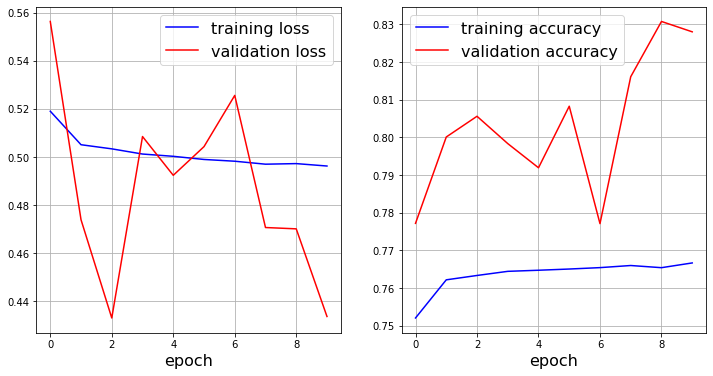

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

### You may train the model for more than 10 epochs and see if you can get a better result

In [ ]:
#optional

In [235]:
#to change the learning rate during traning, we may do this
for g in optimizer.param_groups:
    g['lr']=0.001

### after training, we load the best model from the harddrive and evaluate the model on the test set
You may get a different result because of random initialization of network parameters

In [237]:
filename_best='NN_binary_classification_Pytorch_e9.pt'
load_checkpoint(filename_best, model, optimizer, device)

In [238]:
loss_test, acc_test = test(model, dataloader_test, device)
print('test loss:', loss_test)
print('test accuracy', acc_test)

test loss: 0.4335540512731589
test accuracy 0.8291
